In [15]:
# try to import library, if it is not installed it will be downloaded (required to run code on Google Colab)
import os
try:
  import autoscattering
except:
  if not os.path.isdir('autoscatter'):
    !git clone https://github.com/jlandgr/autoscatter.git
    !mv autoscatter/autoscattering .

In [16]:
import sympy as sp
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import autoscattering.architecture_optimizer as arch_opt
import autoscattering.constraints as msc
import autoscattering.symbolic as sym
np.set_printoptions(linewidth=200)

In this example we reproduce the fully directional phase-preserving and quantum-limited amplifiers shown in Fig. 3(c) in our article [arxiv:2404.14887](https://arxiv.org/abs/2404.14887)

This example is motived by the work of [Liu et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.21.014021)

The goal is to design an amplifier which, which amplifies incoming signal by a factor of $G$, but has no backscattering at the input or output port. There should be no scattering from the output to the input port as the output port is connected to a room-temperature batch.
This corresponds to the target scattering matrix: $S_\mathrm{target} = \begin{pmatrix} 0&0\\ \sqrt{G} & 0 \end{pmatrix}$

Furthermore, the noise at the input and output ports should be at their respective quantum limits. The number of added noise photons at the input (mode 1) and output (mode 2) port can be computed at resonance ($\omega=0$) by:
$
\begin{align}
    N_\mathrm{input}^\mathrm{add}=\frac{1}{2} \sum_{k} \left( (n_k^\mathrm{in}+1) |S_{1k}|^2 + (n_k^\mathrm{noise}+1) |\mathcal{N}_{1k}|^2 \right) \\
    N_\mathrm{output}^\mathrm{add}=\frac{1}{2} \sum_{k\neq 1} \left( (n_k^\mathrm{in}+1) |S_{2k}|^2 + (n_k^\mathrm{noise}+1) |\mathcal{N}_{2k}|^2 \right)
\end{align}
$
$S_{ij}$ are the elements of the full scattering matrix which includes the scattering from and to the auxiliary modes. $\mathcal{N}_{ij}$ describes the linear response to fluctuations entering from the intrinsic loss channels at the port modes.
$n_k^\mathrm{in}$ and $n_k^\mathrm{noise}$ are the occupation numbers of the baths connected to the respective modes. We assume that all the baths are at zero temperature, except the bath connected to the output channel. So, $n_j^\mathrm{in}=0$ if $j\neq 2$, $n_j^\mathrm{noise}=0$ for all $j$, and $n_2^\mathrm{in} > 0$.

The quantum limit for a phase-preserving amplifiers is $N_\mathrm{input}^\mathrm{add}=1/2$ and $N_\mathrm{output}^\mathrm{add}=(G\pm 1)/2$ (see Appendix H in our paper [arxiv:2404.14887](https://arxiv.org/abs/2404.14887) for more details).

The quantum limit condition can not be directly expressed using a target scattering matrix. Instead, we define an extra constraints ($f_j$ in Equ. (1) in [arxiv:2404.14887](https://arxiv.org/abs/2404.14887)).

In the following we define these extra constraints.

In [17]:
class MinimalAddedInputNoise(msc.Base_Constraint):
    def __call__(self, scattering_matrix, coupling_matrix, kappa_int_matrix, mode_types):
        '''
        calculates the difference between the number of added input photons and the quantum limit

        input arguments:
        scattering matrix: full scattering matrix for the current parameter set, this also includes the scattering from and to the auxiliary modes
        coupling matrix: dimensionless coupling matrix (sigma_z @ H in our equations) for the current parameter set, this constraint does not make any use of the coupling matrix
        kappa_int_matrix: diagonal matrix with the dimensionless intrinsic loss rates on the diagonal
        mode_types: whether a mode is part of subset M_1 or M_2 (True for M_1, False for M_2), see Appendix F for more details
        '''

        # calculate the linear response to fluctuations entering from the intrinsic loss channels (\mathcal{N} in the equations above)
        noise_matrix = (scattering_matrix - jnp.eye(scattering_matrix.shape[0])) @ jnp.complex_(jnp.sqrt(kappa_int_matrix))

        # calculate number of added photons at the input port, already considers that the target scattering matrix will be enforced
        total_noise = 1/2 * (jnp.sum(jnp.abs(scattering_matrix[0,2:])**2) + jnp.sum(jnp.abs(noise_matrix[0,:])**2))
        quantum_limit = 1/2
        return total_noise - quantum_limit

class MinimalAddedOutputNoise(msc.Base_Constraint):
    def __init__(self, Gval):
        '''
        Gval: target gain value
        '''
        self.Gval = Gval

    def __call__(self, scattering_matrix, coupling_matrix, kappa_int_matrix, mode_types):
        '''
        calculates the difference between the number of added output photons and the quantum limit

        input arguments:
        scattering matrix: full scattering matrix for the current parameter set, this also includes the scattering from and to the auxiliary modes
        coupling matrix: dimensionless coupling matrix (sigma_z @ H in our equations) for the current parameter set, this constraint does not make any use of the coupling matrix
        kappa_int_matrix: diagonal matrix with the dimensionless intrinsic loss rates on the diagonal
        mode_types: list of boolean values. These values determine whether a mode is part of subset M_1 or M_2 (True for M_1, False for M_2), see Appendix F for more details
        '''

        # calculate the linear response to fluctuations entering from the intrinsic loss channels (\mathcal{N} in the equations above)
        noise_matrix = (scattering_matrix - jnp.eye(scattering_matrix.shape[0])) @ jnp.complex_(jnp.sqrt(kappa_int_matrix))

        # calculate number of added photons at the output port, already considers that the target scattering matrix will be enforced
        total_noise = 1/2 * (jnp.sum(jnp.abs(scattering_matrix[1,2:])**2) + jnp.sum(jnp.abs(noise_matrix[1,:])**2))

        # input_output_part_of_same_set=True means that both modes are part of the same set M_1 or M_2
        # This slightly influences the quantum limit for the output noise
        input_output_part_of_same_set = mode_types[0]==mode_types[1]
        if input_output_part_of_same_set:
            quantum_limit = (self.Gval - 1)/2
        else:
            quantum_limit = (self.Gval + 1)/2

        return total_noise - quantum_limit


In the following, we design the amplifiers with the target behaviour described above. We restrict ourselves to the building blocks used in [Liu et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.21.014021). This excludes intrinsic loss channels for the input and output mode.

To achieve amplification squeezing interactions are required. As described in Section I and Appendix E, we focus on phase-preserving applications. We enforce the phase-preserving property by dividing our mode sets into two subsets $M_1$ (particles) and $M_2$ (holes). Modes within the same subset are exclusively coupled via beamsplitter interactions, modes in different subsets are exclusively coupled via squeezing interactions. Which modes are part of which subset is controlled by the keyword argument mode_types in the optimizer class. This is a list whose length equals the number of modes considered. An entry True means that a mode is a particle, False that it is a hole. All possible systems fulfill particle-hole symmetry, meaning that exchanging all particles by holes and vice versa, leads the same scattering behaviour (besides a complex conjugation of the scattering matrix).

We have to try out all possible particle/hole combinations. However, considering particle-hole symmetry and that the system is symmetric with respect to exchange of auxiliary modes, reduces the amount of combinations. 
Using the function arch_opt.find_minimum_number_auxiliary_modes we automatically find the number of required auxiliary modes and all possible assignments of particles and holes:

In [24]:
Gval = 3. # target gain value
S_target = sp.Matrix([[0,0],[np.sqrt(Gval),0]])
enforced_constraints = [MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval)]

# Set some hyperparameters for the continuous optimisation
kwargs_optimization = {'num_tests': 10} # to reduce the risk of false negative classifications, we repeat the continuous optimization num_test times till a graph is labeled is invalid
solver_options = {'maxiter': 1000} # Furthermore, we increase the maximum number steps within a try

# optimizers contains the optimizers initialized with the respective successful assignments
optimizers = arch_opt.find_minimum_number_auxiliary_modes(
    S_target, enforced_constraints=enforced_constraints, # define target behaviour
    allow_squeezing=True, # allow for squeezing
    port_intrinsic_losses=False, # do not allow for intrinsic port losses (False is also the default option)
    kwargs_optimization=kwargs_optimization, solver_options=solver_options # Set hyperparameters for the optimization
)

testing 0 auxiliary modes
not successfull
testing 1 auxiliary modes
not successfull
testing 2 auxiliary modes
success, minimum number of auxiliary modes is 2
successful assignments of particles and holes:
[ True  True  True False]
[ True False  True False]


So, at least two auxiliary modes are required. The two working assignments of particles and holes are:
- [True, True, True, False] # finds Graph (I), (II) and (UI). Graph (UI) is unstable and only discussed in the Supplemental Material
- [ True, False,  True, False] # finds Graph (III), (IV) and (UII). Graph (UII) is unstable and only discussed in the Supplemental Material

Lets start with the combination [True, True, True, False], the respective optimizer is already correctly initialized in optimizers[0]

In [25]:
list_of_irreducible_graphs = optimizers[0].perform_depth_first_search()

prepare list of all possible graphs


3456it [00:00, 454447.59it/s]


3456 graphs identified
start depth-first search
test all graphs with 16 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


test all graphs with 15 degrees of freedom:


100%|██████████| 7/7 [00:00<00:00, 13.17it/s]


test all graphs with 14 degrees of freedom:


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


test all graphs with 13 degrees of freedom:


100%|██████████| 63/63 [00:07<00:00,  8.62it/s]


test all graphs with 12 degrees of freedom:


100%|██████████| 114/114 [00:19<00:00,  5.89it/s]


test all graphs with 11 degrees of freedom:


100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


test all graphs with 10 degrees of freedom:


100%|██████████| 73/73 [00:03<00:00, 23.13it/s]


test all graphs with 9 degrees of freedom:


100%|██████████| 20/20 [00:00<00:00, 34.94it/s]


test all graphs with 8 degrees of freedom:


100%|██████████| 7/7 [00:00<00:00, 72.72it/s]


test all graphs with 7 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]


optimisation finished, list of irreducible graphs has 7 elements


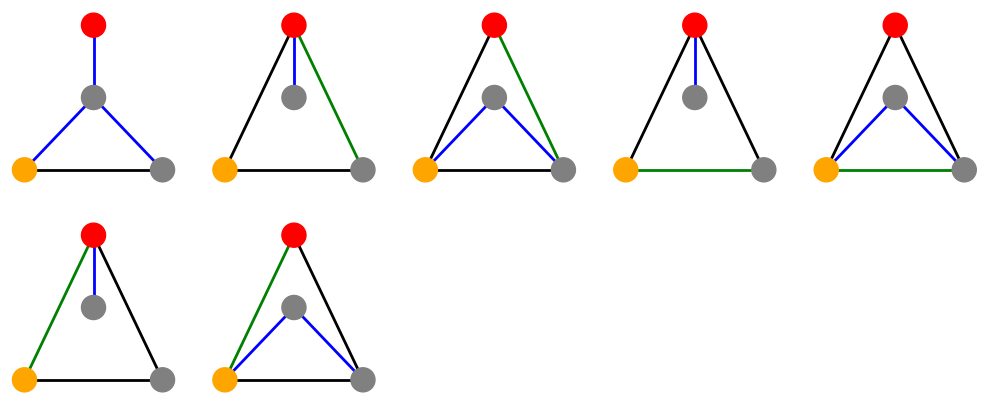

In [26]:
node_colors = ['orange', 'red', 'gray', 'gray'] # the input is orange, the output red, the auxiliary modes are gray
node_positions = [[-1,0],[0,1],[1,0],[0,0.5]]
msc.plot_list_of_graphs(list_of_irreducible_graphs, mode_types=optimizers[0].mode_types, positions=node_positions, node_colors=node_colors)

Now we deal with the combination [True, False, True, False], the respective optimizer is already correctly initialized in optimizers[1]

In [27]:
list_of_irreducible_graphs = optimizers[1].perform_depth_first_search()

prepare list of all possible graphs


2304it [00:00, 603112.80it/s]


2304 graphs identified
start depth-first search
test all graphs with 16 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


test all graphs with 15 degrees of freedom:


100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


test all graphs with 14 degrees of freedom:


100%|██████████| 21/21 [00:06<00:00,  3.46it/s]


test all graphs with 13 degrees of freedom:


100%|██████████| 49/49 [00:04<00:00, 10.62it/s]


test all graphs with 12 degrees of freedom:


100%|██████████| 85/85 [00:16<00:00,  5.06it/s]


test all graphs with 11 degrees of freedom:


100%|██████████| 85/85 [00:02<00:00, 29.22it/s]


test all graphs with 10 degrees of freedom:


100%|██████████| 52/52 [00:00<00:00, 52.77it/s]


test all graphs with 9 degrees of freedom:


100%|██████████| 15/15 [00:00<00:00, 82.06it/s]

test all graphs with 8 degrees of freedom:



0it [00:00, ?it/s]


test all graphs with 7 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 3 elements


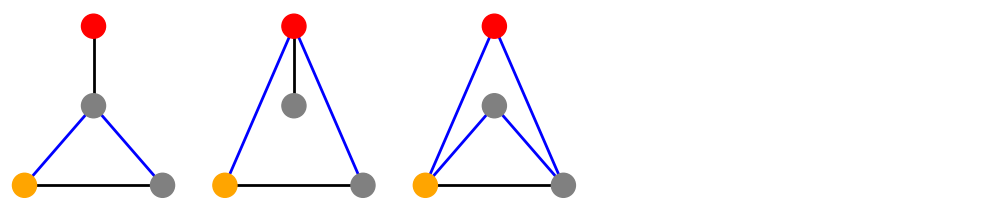

In [28]:
node_colors = ['orange', 'red', 'gray', 'gray'] # the input is orange, the output red, the auxiliary modes are gray
node_positions = [[-1,0],[0,1],[1,0],[0,0.5]]
msc.plot_list_of_graphs(list_of_irreducible_graphs, mode_types=optimizers[1].mode_types, positions=node_positions, node_colors=node_colors)

In the following we will allow for intrinsic losses on the port modes. This building block was not considered in [Liu et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.21.014021).

In [29]:
optimizers = arch_opt.find_minimum_number_auxiliary_modes(
    S_target, enforced_constraints=enforced_constraints, # define target behaviour
    allow_squeezing=True, # allow for squeezing
    port_intrinsic_losses=True, # allow for intrinsic port losses
    kwargs_optimization=kwargs_optimization, solver_options=solver_options # Set hyperparameters for the optimization
)

testing 0 auxiliary modes
not successfull
testing 1 auxiliary modes
success, minimum number of auxiliary modes is 1
successful assignments of particles and holes:
[ True False  True]


In [30]:
list_of_irreducible_graphs = optimizers[0].perform_depth_first_search()

prepare list of all possible graphs


96it [00:00, 470389.23it/s]


96 graphs identified
start depth-first search
test all graphs with 9 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


test all graphs with 8 degrees of freedom:


100%|██████████| 4/4 [00:00<00:00, 34.23it/s]


test all graphs with 7 degrees of freedom:


100%|██████████| 7/7 [00:00<00:00, 10.16it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 1 elements


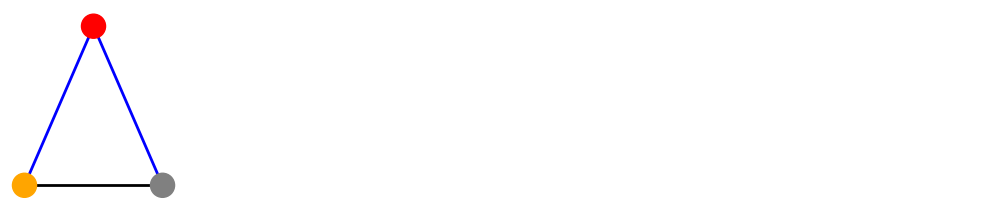

In [35]:
node_colors = ['orange', 'red', 'gray'] # the input is orange, the output red, the auxiliary modes are gray
node_positions = [[-1,0],[0,1],[1,0]]
msc.plot_list_of_graphs(list_of_irreducible_graphs, mode_types=optimizers[0].mode_types, positions=node_positions, node_colors=node_colors)

In the following we analyse and generalise Graph (V) detected by the previous cells. So far, we always kept the gain value fixed. However, we want to find the general behaviour for arbitrary gain values. Playing around with the gain value, it is easy to see, that the cooperativities equal $C_{0,1}=C_{1,2}=G$ and $C_{0,2}=1$ and the dimensionless intrinsic loss rates equal $\gamma_0=0$ and $\gamma_1=G+1$.

In [32]:
Gval = 5. # target gain value
mode_types = [True, False, True] # defines which modes are particles and which are holes

optimizer = arch_opt.Architecture_Optimizer(
    S_target=sp.Matrix([[0,0],[np.sqrt(Gval),0]]),
    num_auxiliary_modes=1,
    mode_types=mode_types,
    port_intrinsic_losses=True, # allows an additional intrinsic loss channel for input and output port
    enforced_constraints=[MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval)],
    kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
    solver_options={'maxiter': 2000},
    make_initial_test=False
)

success, infos, _ = optimizer.repeated_optimization(triu_matrix=list_of_irreducible_graphs[0], **optimizer.kwargs_optimization, **optimizer.solver_options)
print('optimisation was successful:', success)
infos[-1]['parameters_for_analysis']

optimisation was successful: True


{'C_{0,1}': 4.999893863548415,
 'C_{0,2}': 0.9999890019327009,
 'C_{1,2}': 4.999968545433196,
 '\\gamma_0': 3.9625870432642266e-08,
 '\\gamma_1': 5.9999503756103385}

In [33]:
Gvals = np.linspace(1.1, 5., 20)
list_C01 = []
list_C02 = []
list_C12 = []
list_gamma0 = []
list_gamma1 = []

for Gval in Gvals:
    optimizer = arch_opt.Architecture_Optimizer(
        S_target=sp.Matrix([[0,0],[np.sqrt(Gval),0]]),
        num_auxiliary_modes=1,
        mode_types=[True, False, True], # defines whether modes are particles or holes
        port_intrinsic_losses=True, # allows an additional intrinsic loss channel for input and output port
        enforced_constraints=[MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval)],
        kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
        solver_options={'maxiter': 2000},
        make_initial_test=False
    )

    success, infos, _ = optimizer.repeated_optimization(triu_matrix=list_of_irreducible_graphs[0], **optimizer.kwargs_optimization, **optimizer.solver_options)
    print('optimisation was successful:', success)
    list_C01.append(infos[-1]['parameters_for_analysis']['C_{0,1}'])
    list_C02.append(infos[-1]['parameters_for_analysis']['C_{0,2}'])
    list_C12.append(infos[-1]['parameters_for_analysis']['C_{1,2}'])
    list_gamma0.append(infos[-1]['parameters_for_analysis']['\\gamma_0'])
    list_gamma1.append(infos[-1]['parameters_for_analysis']['\\gamma_1'])

optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True


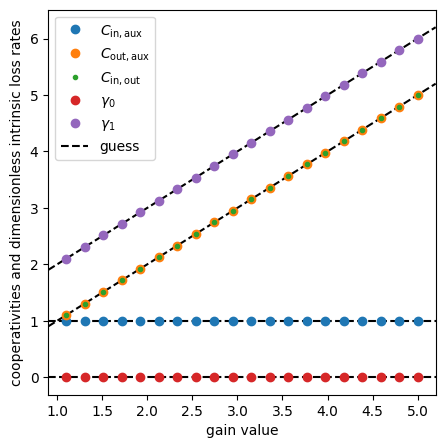

In [34]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(Gvals, list_C02, ls='None', marker='o', label='$C_\mathrm{in,aux}$')
ax.plot(Gvals, list_C12, ls='None', marker='o', label='$C_\mathrm{out,aux}$')
ax.plot(Gvals, list_C01, ls='None', marker='o', label='$C_\mathrm{in,out}$', markersize=3)
ax.plot(Gvals, list_gamma0, ls='None', marker='o', label='$\gamma_0$')
ax.plot(Gvals, list_gamma1, ls='None', marker='o', label='$\gamma_1$')

# plot dependencies for the parameter values
xs = np.linspace(Gvals[0]-.2, Gvals[-1]+.2)
ax.axhline(1., label='guess', ls='dashed', color='black', zorder=-100)
ax.axhline(0., ls='dashed', color='black', zorder=-100)
ax.plot(xs, xs, ls='dashed', color='black', zorder=-100)
ax.plot(xs, xs+1, ls='dashed', color='black', zorder=-100)
ax.set_xlabel('gain value')
ax.set_ylabel('cooperativities and dimensionless intrinsic loss rates')
ax.set_xlim(xs[0], xs[-1])
ax.legend()

In a similar way the other amplifiers with two auxiliary modes can be analysed. The easiest way to find the symbolic expressions is to find first the symbolic expressions for the full scattering matrix including the scattering from and to the auxiliary modes. The coupling matrix can then be computed by simple matrix inversion. The resulting coupling rates are provided in the Supplemental Material in [arxiv:2404.14887](https://arxiv.org/abs/2404.14887).